# Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

<img src="../images/Riess.png" alt="Description" width="600" />
Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data

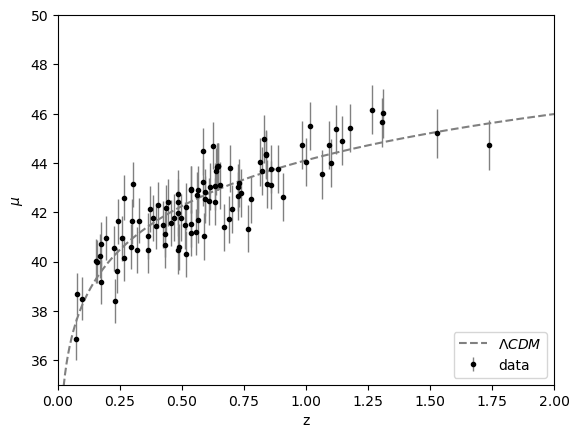

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.datasets import generate_mu_z

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

# WE already know the solution...

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)
plt.plot(z, mu_true, '--', c='gray',label='$\Lambda CDM$')


plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

# Linear and Polynomial Regressions

In [7]:
# sklearn format

X = z_sample[:,np.newaxis]
print(X.shape)

y = mu_sample 
print(y.shape)

dy = dmu 
print(dy.shape)

(100, 1)
(100,)
(100,)


39.604564811058694 [4.5911933]


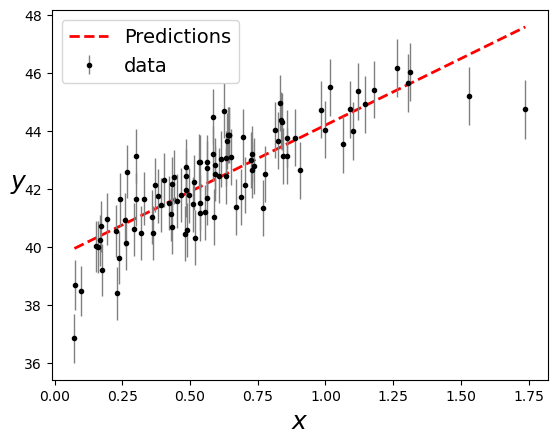

In [5]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y, dy)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

X_new = np.linspace(min(z_sample),max(z_sample))
X_new = X_new[:,np.newaxis]

y_pred = lin_reg.predict(X_new)

plt.plot(X_new, y_pred, "r--", linewidth=2, label="Predictions")
plt.errorbar(X, y, dy,  fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()


(35.0, 50.0)

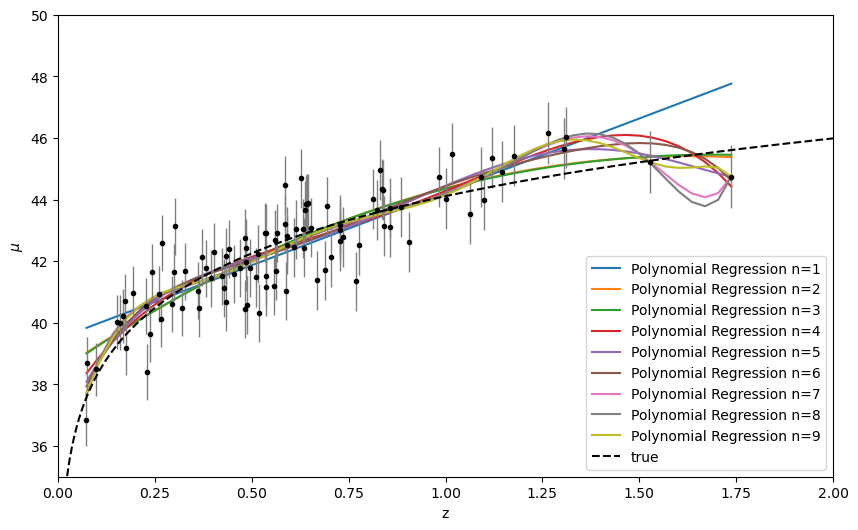

In [10]:
# Polynomial Regression
fig,_=plt.subplots(figsize=(10,6))

from astroML.linear_model import PolynomialRegression

z = np.linspace(min(z_sample),max(z_sample))

for n in range(1,10):

    regressor = PolynomialRegression(n)
    regressor.fit(X, y, dy)
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Polynomial Regression n='+str(n))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)
plt.plot(z, mu_true, '--', c='black',label='true')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)



# Cross Validation with simple Train-Test split

Result strongly depends on which points are randomly picked as train points and which as validation points. 
K-fold validation is required.

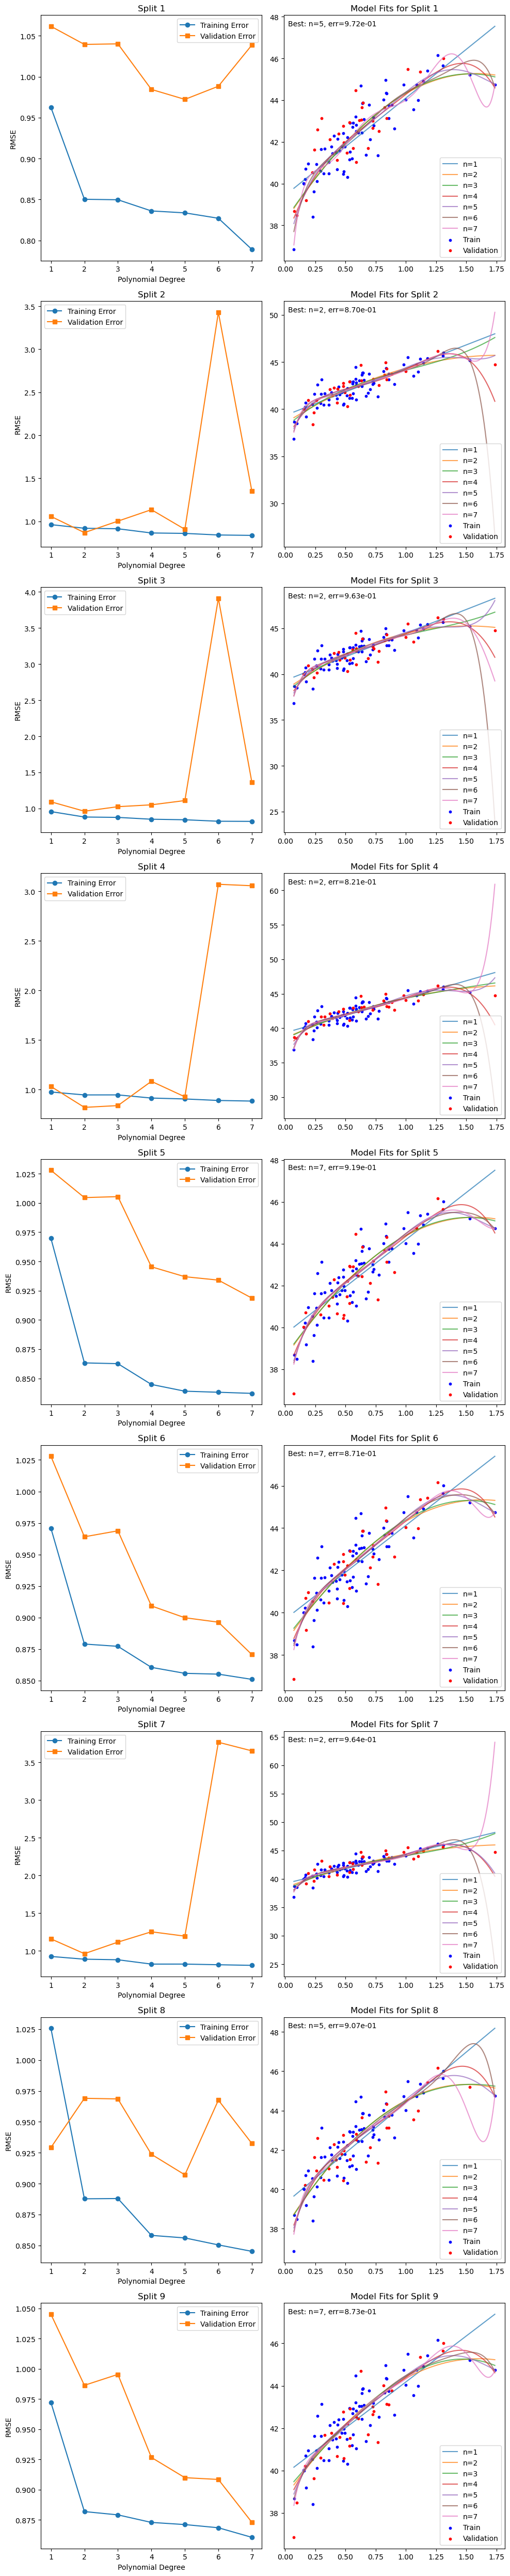

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from astroML.linear_model import PolynomialRegression

# Define RMSE loss function
def loss_function(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Settings
n_splits = 9
nrange = range(1, 8)
z = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)

fig, ax = plt.subplots(n_splits, 2, figsize=(10, 50))

for i in range(n_splits):
    # Random split
    X_train, X_val, ydy_train, ydy_val = train_test_split(
        X, np.column_stack([y, dy]),
        test_size=0.3,
        shuffle=True,
        random_state=None
    )
    y_train, dy_train = ydy_train.T
    y_val, dy_val = ydy_val.T

    etrain, evalidation = [], []

    for n in nrange:
        model = PolynomialRegression(n)
        model.fit(X_train, y_train, dy_train)

        # Predict and compute errors
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        etrain.append(loss_function(y_train, y_pred_train))
        evalidation.append(loss_function(y_val, y_pred_val))

        # Plot model curve
        y_model = model.predict(z)
        ax[i, 1].plot(z, y_model, label=f"n={n}", alpha=0.7)

    # Plot error vs. degree
    ax[i, 0].plot(nrange, etrain, label='Training Error', marker='o')
    ax[i, 0].plot(nrange, evalidation, label='Validation Error', marker='s')
    ax[i, 0].set_xlabel('Polynomial Degree')
    ax[i, 0].set_ylabel('RMSE')
    ax[i, 0].legend()
    ax[i, 0].set_title(f"Split {i+1}")

    # Plot data points
    ax[i, 1].scatter(X_train, y_train, c='blue', label='Train', s=10)
    ax[i, 1].scatter(X_val, y_val, c='red', label='Validation', s=10)
    best_n = nrange[np.argmin(evalidation)]
    best_error = min(evalidation)

    # Annotate best model
    ax[i, 1].text(
        0.02, 0.98,
        f"Best: n={best_n}, err={best_error:.2e}",
        transform=ax[i, 1].transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=10
    )
    ax[i, 1].legend(loc='lower right')
    ax[i, 1].set_title(f"Model Fits for Split {i+1}")

plt.tight_layout()
plt.show()


# K-fold cross-validation

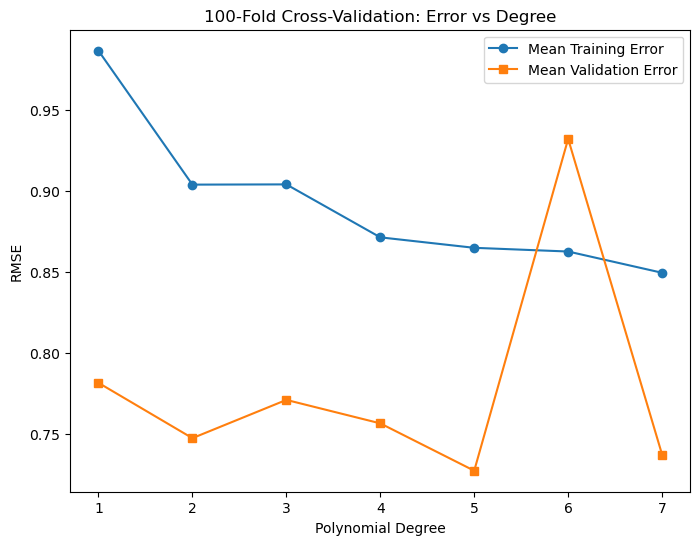

Best degree = 5, Validation RMSE = 0.7270


In [12]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from astroML.linear_model import PolynomialRegression

# Loss function: Root Mean Squared Error
def loss_function(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Setup
nrange = range(1, 8)       # Polynomial degrees to test
K = 100                    # Number of folds (IF EQUAL TO THE NUMBER OF POINTS THIS IS THE LEAVE ONE OUT K-FOLD)
kf = KFold(n_splits=K, shuffle=True, random_state=42)

mean_train_errors = []
mean_val_errors = []

# Loop over degrees
for n in nrange:
    train_errors = []
    val_errors = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        dy_train, dy_val = dy[train_idx], dy[val_idx]

        model = PolynomialRegression(n)
        model.fit(X_train, y_train, dy_train)

        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_errors.append(loss_function(y_train, y_pred_train))
        val_errors.append(loss_function(y_val, y_pred_val))

    mean_train_errors.append(np.mean(train_errors))
    mean_val_errors.append(np.mean(val_errors))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(nrange, mean_train_errors, 'o-', label='Mean Training Error')
plt.plot(nrange, mean_val_errors, 's-', label='Mean Validation Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title(f"{K}-Fold Cross-Validation: Error vs Degree")
plt.legend()
plt.show()

# Best model selection
best_n = nrange[np.argmin(mean_val_errors)]
print(f"Best degree = {best_n}, Validation RMSE = {min(mean_val_errors):.4f}")

# Learning Curve

Of course more data means a better fit... but a some point data are all the same!

We can use a tool called a **[learning curve](https://en.wikipedia.org/wiki/Learning_curve)** to determine if (for a given model) having more training data would help improve the model fitting. This is a different question than above-- rather than try to get a better model of the data, we're trying to improve the quality of our data set. 

The training and CV error are computed as a function of the number of training points. In general:
- ***The training error increases with $N_\mathrm{train}$.*** For a given model, it's easier to fit fewer data points.
- ***The CV error decreases wtih $N_\mathrm{train}$.*** For a given model, a greater number of training points reduces the chances of over-fitting, resulting in better performance of the model in the cross-validation stage.

Let's look at this for the same data and model as above.

1. ***The training and CV errors have converged.*** This indicates that the model is dominated by bias. Increasing the number of training points is futile. If the error is too high, you instead need a more complex model, not more training data.
2. ***The training error is smaller than the CV error.*** This indicates that the model is dominated by variance.  Increasing the number of training points may help to improve the model.

In both cases, for small numbers of training points, the difference between the training and CV errors indicates that more data well help.  

For the top plot, the convergence of the training and CV errors indicates that adding further data will not reduce the error as it is dominated by ***bias***. A more sophisticated model is needed. The training error starts at zero because we are predicting the training data perfectly, but the CV error is high, indicating that the training data aren't sufficiently representative.

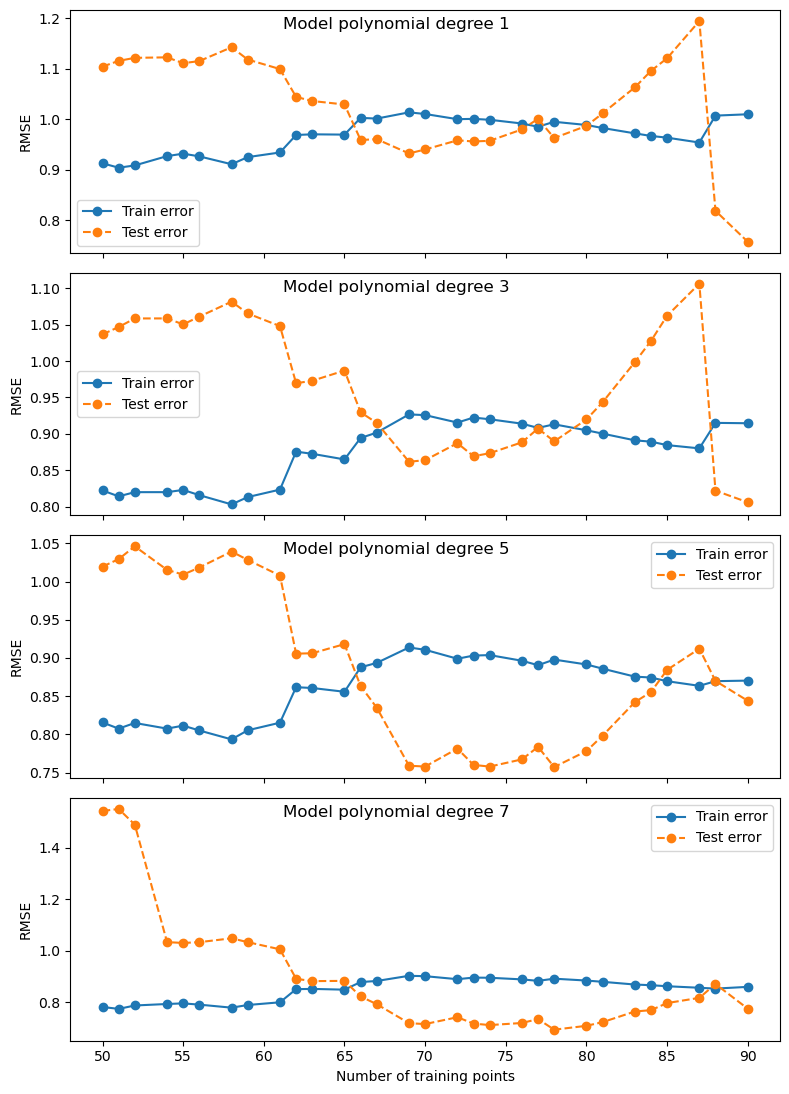

In [15]:
# Loss function
def loss_function(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Set up plot
fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)
degrees = [1, 3, 5, 7]

for i, n in enumerate(degrees):
    train_errors = []
    test_errors = []
    train_sizes = []

    for test_size in np.linspace(0.5,0.1,30): #[0.5, 0.4, 0.3, 0.2]:
        # Determine number of training points
        n_train = int(len(X) * (1 - test_size))
        train_sizes.append(n_train)

        # Split the dataset
        X_train, X_test, y_train_full, y_test_full = train_test_split(
            X, np.column_stack([y, dy]), test_size=test_size, shuffle=True, random_state=0
        )

        # Extract uncertainties and targets
        y_train = y_train_full[:, 0]
        dy_train = y_train_full[:, 1]

        y_test = y_test_full[:, 0]
        dy_test = y_test_full[:, 1]

        # Fit model
        model = PolynomialRegression(n)
        model.fit(X_train, y_train, dy_train)

        # Predict on train and test sets
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Evaluate loss
        train_errors.append(loss_function(y_train, y_pred_train))
        test_errors.append(loss_function(y_test, y_pred_test))


    ax = axs[i]
    ax.plot(train_sizes, train_errors, 'o-', label='Train error')
    ax.plot(train_sizes, test_errors, 'o--', label='Test error')
    ax.set_ylabel(f'RMSE')
    ax.text(0.3,0.85,f'Model polynomial degree {n}\n', fontsize=12, transform=ax.transAxes)
    ax.legend()
    #ax.grid(True)

axs[-1].set_xlabel('Number of training points')
#plt.suptitle('Learning Curves for Polynomial Regression')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Basis function regression and Kernel regression

Both basis function regression and kernel regression are techniques for modeling nonlinear relationships, but they take very different approaches under the hood.

In **basis function regression** you manually choose a set of nonlinear basis functions $\phi_j(x)$, then do linear regression on their outputs:
$$
y(x)=\sum_{j=1}^Mw_j\phi_j(x)
$$
- Explicit model; interpretable
- Fast at test time once trained
- Easy to regularize (e.g., ridge regression)
- $M$ is the number of basis functions used to approximate the target function. It's an hyperparameter. Too low $M$: under-fit. Too high $M$: over-fit

**Kernel regression** is non parametric. You don't choose basis functions — instead, you let the training data themselves define the model via a kernel function. You use the same Gaussian, but center one at every training point, and don’t learn weights — just average the responses.

Given a kernel $K(x_i,x)$ (e.g., a Gaussian or top-hat) at each point we estimate the function value by

$$f(x|K) = \frac{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right) y_i}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)},$$

which is a weighted sum of $y$ (weighted by distance) with

$$w_i(x) = \frac{ K\left( \frac{||x_i-x||}{h} \right)}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)}.$$

This **locally weighted regression** technique drives the regressed value to the nearest neighbor (when we have few points) which helps with extrapolation issues. As we saw with KDE, defining the correct bandwidth of the kernel is more important than the shape of the kernel itself and is done through **cross-validation**.

If you skip the denominator in kernel regression:
- You're not normalizing the weights.
- The output becomes a raw sum of weighted contributions instead of a weighted average.
- Magnitude depends on sample density: In regions with many data points, the output will be larger (the sum of Gaussians is higher).In sparse regions, it will be smaller, even if the underlying function is the same. Your model will be biased by how many samples exist nearby.

# Basis function regression

In [1]:
from astroML.linear_model import BasisFunctionRegression
from scipy.stats import norm

# Define Gaussian basis parameters
mu_vals = np.linspace(0, 2, 10)[:, None]  # centers of Gaussians, FIXED, not depending on the points
print(mu_vals)
sigma_val = 0.1                           # common width

model = BasisFunctionRegression('gaussian', mu=mu_vals, sigma=sigma_val)
model.fit(X, y, dy)

y_pred = model.predict(X)
print(model.coef_)

# BasisFunctionRegression automatically adds a bias term (intercept) to the model by default. 
# That’s why model.coef_ has 11 elements even though you only specified 10 Gaussian basis functions.


/home/utente/anaconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


NameError: name 'np' is not defined

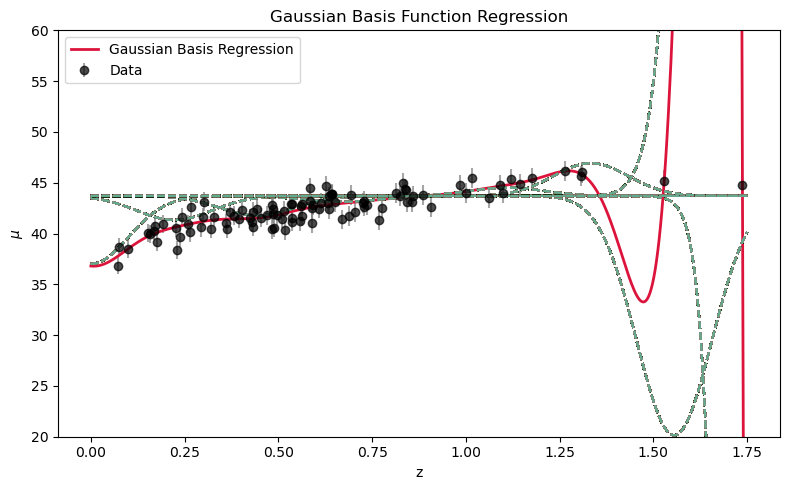

In [19]:
# Predict at fine-grained x values for plotting
x_plot = np.linspace(0, 1.75, 500)[:, None]
y_plot = model.predict(x_plot)

# Plot the data and model
plt.figure(figsize=(8, 5))
plt.errorbar(X.ravel(), y, dy, fmt='o', label='Data', color='black', ecolor='gray', alpha=0.7)
plt.plot(x_plot, y_plot, label='Gaussian Basis Regression', color='crimson', lw=2)

intercept = model.coef_[0]

for i, (mu_i, coef_i) in enumerate(zip(mu_vals.ravel(), model.coef_[1:])):
    basis_curve = np.full(len(x_plot), intercept) + coef_i * norm.pdf(x_plot, loc=mu_i, scale=sigma_val)
    plt.plot(x_plot, basis_curve, '--', alpha=0.5)

plt.ylim(20,60)
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend()
plt.title('Gaussian Basis Function Regression')

plt.tight_layout()
plt.show()

# Cross Validation for basis function regression

Best model: 9 Gaussians, Validation RMSE = 0.7527


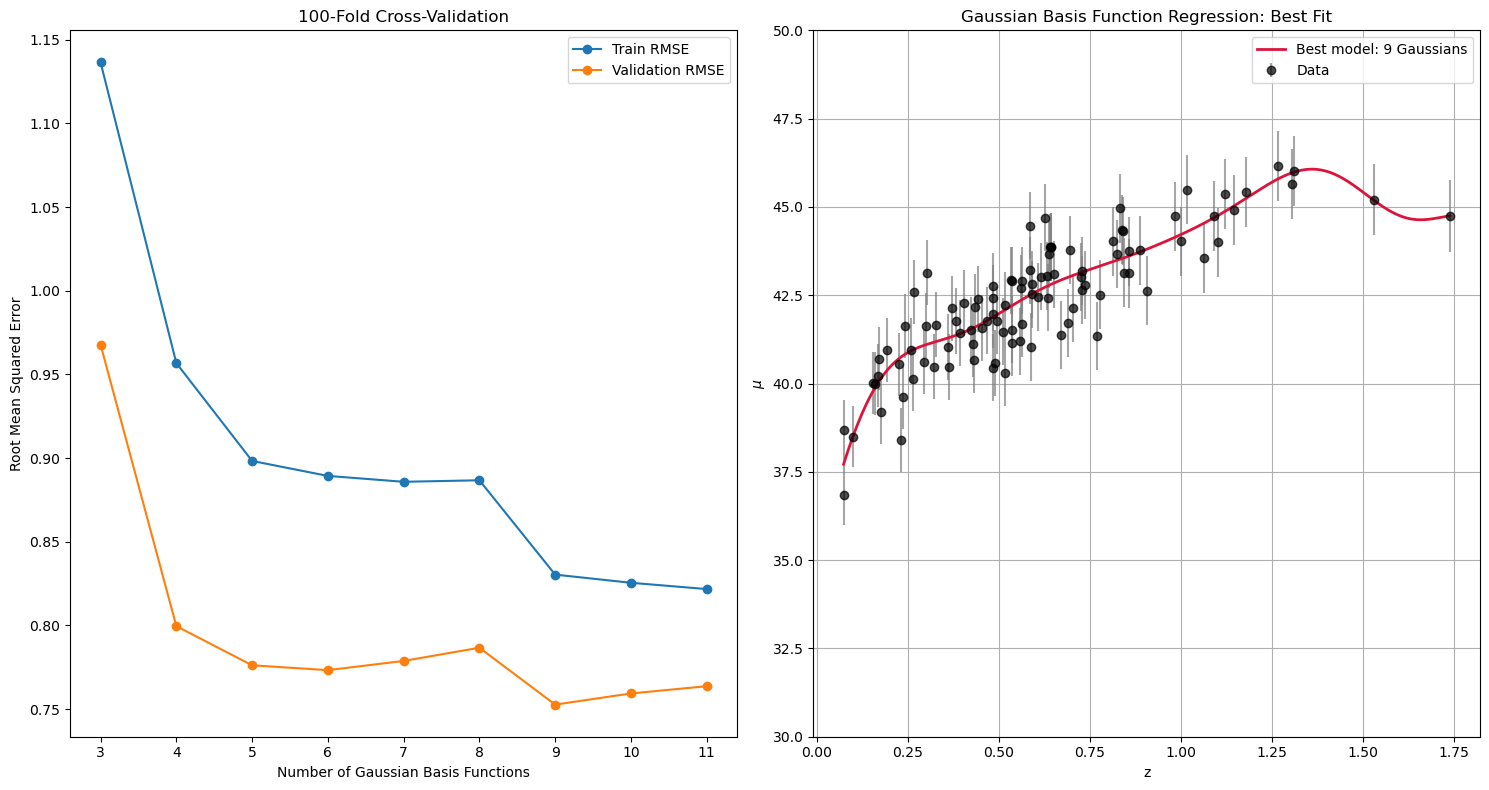

In [27]:
from sklearn.model_selection import KFold
from astroML.linear_model import BasisFunctionRegression

# -----------------------------
# Loss function: RMSE
def loss_function(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# -----------------------------
# Plot setup
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# -----------------------------
# Cross-validation setup
nrange = range(3, 12)  # Number of Gaussians
K = 100                # Number of folds (K=number of points → Leave-One-Out)
kf = KFold(n_splits=K, shuffle=True, random_state=42)

mean_train_errors = []
mean_val_errors = []
std_train_errors = []
std_val_errors = []

# -----------------------------
# Cross-validation loop
for n in nrange:
    train_errors = []
    val_errors = []

    mu_vals = np.linspace(0.1, 0.9, n)[:, None]  # Gaussian centers
    sigma_val = 0.1                          # Common Gaussian width

    for train_idx, val_idx in kf.split(X):         # HERE CROSS VALIDATION
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        dy_train, dy_val = dy[train_idx], dy[val_idx]

        model = BasisFunctionRegression('gaussian', mu=mu_vals, sigma=sigma_val)
        model.fit(X_train, y_train, dy_train)

        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_errors.append(loss_function(y_train, y_pred_train))
        val_errors.append(loss_function(y_val, y_pred_val))

    mean_train_errors.append(np.mean(train_errors))
    mean_val_errors.append(np.mean(val_errors))
    std_train_errors.append(np.std(train_errors))
    std_val_errors.append(np.std(val_errors))

# -----------------------------
# Plot validation curves
ax[0].plot(nrange, mean_train_errors, marker='o',label='Train RMSE') #yerr=std_train_errors,
ax[0].plot(nrange, mean_val_errors,marker='o', label='Validation RMSE') #yerr=std_val_errors,

ax[0].set_xlabel('Number of Gaussian Basis Functions')
ax[0].set_ylabel('Root Mean Squared Error')
ax[0].set_title(f"{K}-Fold Cross-Validation")
ax[0].legend()
#ax[0].grid(True)

# -----------------------------
# Select best model and fit full data
best_n = nrange[np.argmin(mean_val_errors)]
print(f"Best model: {best_n} Gaussians, Validation RMSE = {min(mean_val_errors):.4f}")

mu_vals = np.linspace(0.1, 1.9, best_n)[:, None]
sigma_val = 0.2
model = BasisFunctionRegression('gaussian', mu=mu_vals, sigma=sigma_val)
model.fit(X, y, dy)

# -----------------------------
# Plot best model
x_plot = np.linspace(X.min(), X.max(), 500)[:, None]
y_plot = model.predict(x_plot)

ax[1].errorbar(X.ravel(), y, dy, fmt='o', color='black', label='Data', ecolor='gray', alpha=0.7)
ax[1].plot(x_plot, y_plot, label=f'Best model: {best_n} Gaussians', color='crimson', lw=2)

ax[1].set_ylim(30, 50)
ax[1].set_xlabel('z')
ax[1].set_ylabel(r'$\mu$')
ax[1].legend()
ax[1].set_title('Gaussian Basis Function Regression: Best Fit')
ax[1].grid(True)

plt.tight_layout()
plt.show()


# Kernel Regression

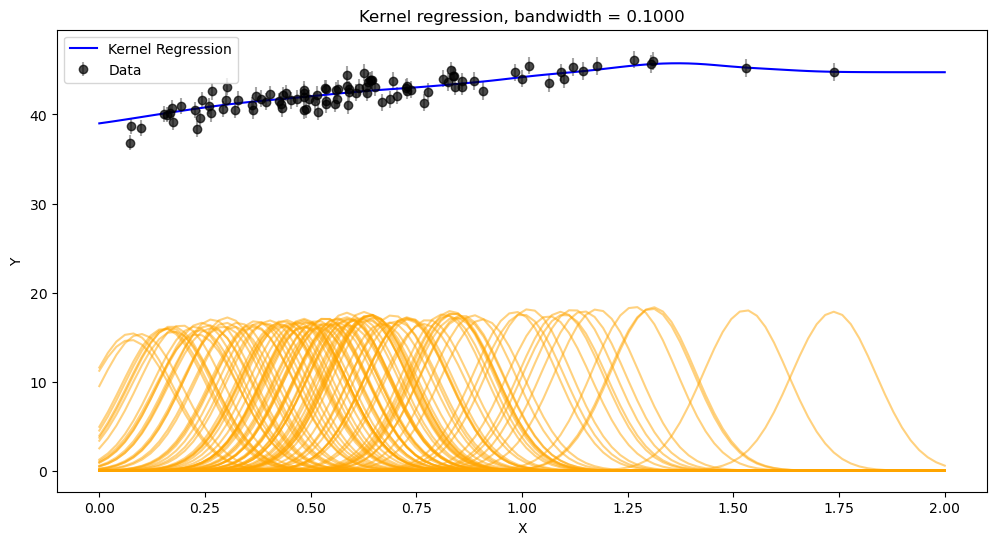

In [33]:
import numpy as np
import matplotlib.pyplot as plt

x = X.ravel()

# Gaussian kernel
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Kernel regression
def kernel_regression(x_train, y_train, x_query, bandwidth):
    y_pred = []
    for xq in x_query:
        weights = gaussian_kernel((xq - x_train) / bandwidth)
        weighted_avg = np.sum(weights * y_train) / np.sum(weights)
        y_pred.append(weighted_avg)
    return np.array(y_pred)

# Parameters
bandwidth = 0.1
x_query = np.linspace(0, 2, 100)
y_pred = kernel_regression(x, y, x_query, bandwidth)

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(X.ravel(), y, dy, fmt='o', color='black', label='Data', ecolor='gray', alpha=0.7)
plt.plot(x_query, y_pred, color='blue', label='Kernel Regression')

xs = np.linspace(0, 2, 100)
for xi, yi in zip(X, y):
    kernel_vals = gaussian_kernel((xs - xi) / bandwidth)
    scaled_kernel = kernel_vals * yi 
    plt.plot(xs, scaled_kernel, color='orange', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Kernel regression, bandwidth = {bandwidth:.4f}')
plt.legend()
plt.show()

## Cross validation to find the optimal bandwidth

You tried to use GridSearchCV from scikit-learn to tune the bandwidth h. GridSearchCV expects the model you pass to it to behave like a scikit-learn estimator, which means it should:

- Implement a fit(X, y) method.
- Implement a predict(X) method.
- Have get_params() and set_params() methods.

The astroML.linear_model.NadarayaWatson class has fit() and predict(), but does not fully implement get_params() and set_params() in a way that scikit-learn expects. Therefore, GridSearchCV would raise an error like:

`TypeError: Cannot clone object 'model' (type <class 'NadarayaWatson'>): it does not seem to be a scikit-learn estimator.`

`NWWrapper` wrapper subclasses NadarayaWatson and adds get_params() and set_params():

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from astroML.linear_model import NadarayaWatson

import warnings
warnings.filterwarnings("ignore")


# Define a custom regressor wrapper for GridSearchCV
class NWWrapper(NadarayaWatson):
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    def get_params(self, deep=False):
        return {"h": self.h, "kernel": self.kernel}

# Candidate bandwidths
h_values = np.linspace(1e-2, 1, 1000)

model = NWWrapper(kernel='gaussian')
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid = GridSearchCV(model, param_grid={'h': h_values}, scoring=scorer, cv=5)  # len(X) leave-one-out CV
grid.fit(X, y)

best_h = grid.best_params_['h']
print(f"Optimal bandwidth: {best_h:.4f}")

Optimal bandwidth: 0.0308


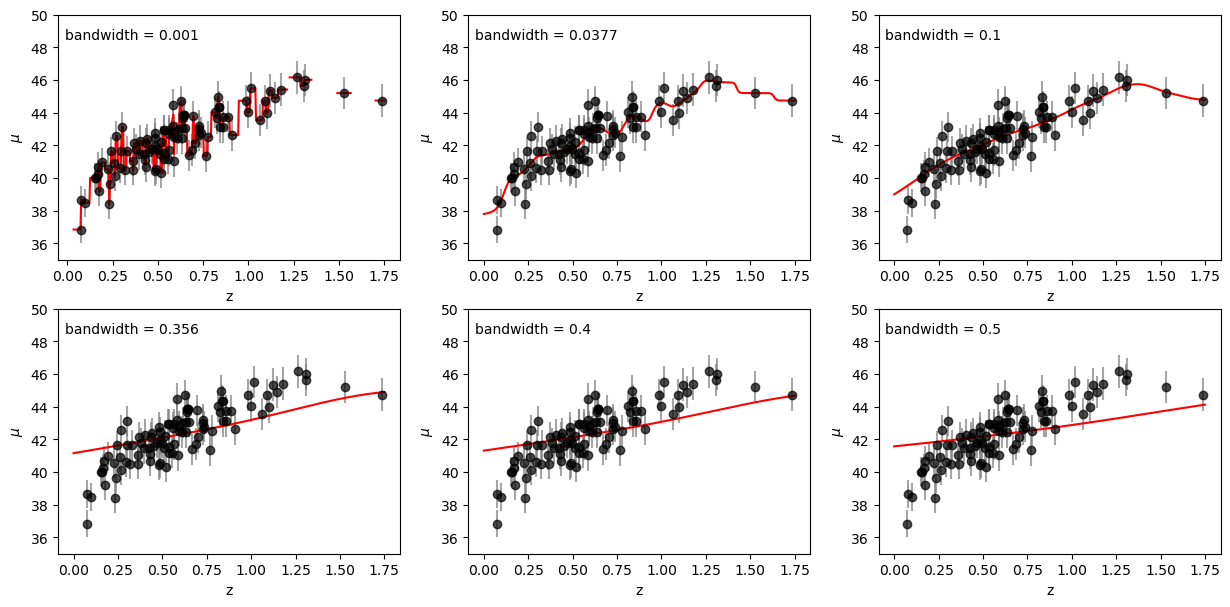

In [31]:
fig,ax = plt.subplots(2,3,figsize=(15,7))
ax = ax.flatten()

for i,h in enumerate([0.001, 0.0377, 0.1, 0.356, 0.4, 0.5]):

    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(X,y)
    
    x_grid = np.linspace(0, 1.75, 500)[:, np.newaxis] 
    y_pred = model.predict(x_grid)
    
    ax[i].errorbar(X.ravel(), y, dy, fmt='o', color='black', label='Data', ecolor='gray', alpha=0.7)
    ax[i].plot(x_grid,y_pred,c='red',label=f'Kernel regression, bandwidth = {h:.3f}')
    ax[i].text(0.02,0.9,f'bandwidth = {h}', transform=ax[i].transAxes)


    ax[i].set_ylim(35, 50)
    ax[i].set_xlabel('z')
    ax[i].set_ylabel(r'$\mu$')



plt.show()

Yes, you can combine kernel regression and LASSO/Ridge ideas — but not directly in the standard Nadaraya-Watson sense.

Kernel regression (like Nadaraya-Watson) is a non-parametric method: it doesn’t learn coefficients; instead, it makes predictions via weighted averages of nearby training points. LASSO/Ridge are parametric methods: they apply penalties to coefficients in a linear model.
So, LASSO/Ridge don’t apply directly to kernel regression because there are no coefficients to penalize.
